In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import seaborn as sns
import statsmodels.api as sm
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime

In [2]:
train = pd.read_excel("Train.xlsx")
test = pd.read_excel("Test.xlsx")
sol = pd.read_csv("Sample submission.csv")

In [3]:
print(train.shape)
print(test.shape)
print(sol.shape)

(24000, 14)
(6000, 13)
(6000, 2)


In [4]:
train.drop(14409,inplace=True)
train.reset_index(drop=True,inplace=True)

In [5]:
train["split"] = "train"
test["split"] = "test"

In [6]:
test = pd.merge(left=test,right=sol,on="TripID",how="inner")

In [7]:
df = pd.concat([train,test])

In [8]:
df.shape

(29999, 15)

In [9]:
df.head()

,TripID,departure,arrival,airline,planecode,plane,Bookingdate,currencyCode,departure_airport,departure_date_time,arrival_airport,arrival_date_time,Route,ticketprice,split
0,Trip8907,Bengaluru,Delhi,Vistara,320,Airbus A320,23May2017-12:40:46,INR,"Bengaluru, India (BLR-Kempegowda Intl.)",24/05/2017 06:40,Delhi (DEL-Indira Gandhi Intl.),24/05/2017 14:10,BLR-BOM-DEL,10884,train
1,Trip19142,Hyderabad,Pune,Vistara,320,Airbus A320,28May2017-15:22:34,INR,Hyderabad (HYD-Rajiv Gandhi Intl.),01/06/2017 10:10,Pune (PNQ-Lohegaon),02/06/2017 05:20,HYD-DEL-PNQ,21189,train
2,Trip4364,Hyderabad,Chennai,Indigo,320,Airbus A320,21May2017-18:05:45,INR,Hyderabad (HYD-Rajiv Gandhi Intl.),26/05/2017 16:35,Chennai (MAA-Chennai Intl.),26/05/2017 17:50,HYD-MAA,5001,train
3,Trip43336,Hyderabad,Goa,Indigo,320,Airbus A320,02June2017-14:57:27,INR,Hyderabad (HYD-Rajiv Gandhi Intl.),15/06/2017 12:50,Goa (GOI-Dabolim),15/06/2017 14:15,HYD-GOI,2622,train
4,Trip2628,Bengaluru,Hyderabad,Indigo,320,Airbus A320,21May2017-17:14:38,INR,"Bengaluru, India (BLR-Kempegowda Intl.)",25/05/2017 08:20,Hyderabad (HYD-Rajiv Gandhi Intl.),25/05/2017 09:30,BLR-HYD,16704,train


In [10]:
df.describe()

,ticketprice
count,29999.000000
mean,8544.943865
std,9465.046729
min,500.000000
25%,3082.000000
50%,6082.000000
75%,10813.000000
max,129732.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TripID               29999 non-null  object
 1   departure            29999 non-null  object
 2   arrival              29999 non-null  object
 3   airline              29999 non-null  object
 4   planecode            29999 non-null  object
 5   plane                29999 non-null  object
 6   Bookingdate          29999 non-null  object
 7   currencyCode         29999 non-null  object
 8   departure_airport    29999 non-null  object
 9   departure_date_time  29999 non-null  object
 10  arrival_airport      29999 non-null  object
 11  arrival_date_time    29999 non-null  object
 12  Route                29999 non-null  object
 13  ticketprice          29999 non-null  int64 
 14  split                29999 non-null  object
dtypes: int64(1), object(14)
memory usage: 3.7+ MB


In [12]:
df.nunique()

TripID                 29999
departure                  4
arrival                   20
airline                    3
planecode                  5
plane                      6
Bookingdate            14003
currencyCode               1
departure_airport          5
departure_date_time     5648
arrival_airport           21
arrival_date_time       5814
Route                    140
ticketprice             4404
split                      2
dtype: int64

In [13]:
df['departure_date_time'] = pd.to_datetime(df.departure_date_time,format="%d/%m/%Y %H:%M")
df['arrival_date_time'] = pd.to_datetime(df.arrival_date_time,format="%d/%m/%Y %H:%M")
df['Bookingdate'] = pd.to_datetime(df.Bookingdate,format="%d%B%Y-%H:%M:%S")

In [14]:
df['flight_duration'] = df['arrival_date_time'] - df['departure_date_time']

In [15]:
# how early did the flight booking take place
df['booking_interval'] = df['departure_date_time'] - df['Bookingdate']

In [16]:
flight_seconds = df.flight_duration.dt.total_seconds()

# days, remainder = divmod(flight_seconds, 86400)
# hours, remainder = divmod(remainder, 3600)
# minutes, seconds = divmod(remainder, 60)
hours = flight_seconds / 3600

# df['flight_duration_day'] = days
df['flight_duration_hour'] = hours
# df['flight_duration_minute'] = minutes

In [17]:
flight_seconds = df.booking_interval.dt.total_seconds()

hours = flight_seconds / 3600
# minutes, seconds = divmod(remainder, 60)

# df['booking_interval_day'] = days
df['booking_interval_hour'] = hours
# df['booking_interval_minute'] = minutes

In [18]:
train_index = df[df.split=="train"].index
test_index = df[df.split=="test"].index

In [19]:
df.nunique()

TripID                   29999
departure                    4
arrival                     20
airline                      3
planecode                    5
plane                        6
Bookingdate              14003
currencyCode                 1
departure_airport            5
departure_date_time       5648
arrival_airport             21
arrival_date_time         5814
Route                      140
ticketprice               4404
split                        2
flight_duration            261
booking_interval         27870
flight_duration_hour       261
booking_interval_hour    27870
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 5999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   TripID                 29999 non-null  object         
 1   departure              29999 non-null  object         
 2   arrival                29999 non-null  object         
 3   airline                29999 non-null  object         
 4   planecode              29999 non-null  object         
 5   plane                  29999 non-null  object         
 6   Bookingdate            29999 non-null  datetime64[ns] 
 7   currencyCode           29999 non-null  object         
 8   departure_airport      29999 non-null  object         
 9   departure_date_time    29999 non-null  datetime64[ns] 
 10  arrival_airport        29999 non-null  object         
 11  arrival_date_time      29999 non-null  datetime64[ns] 
 12  Route                  29999 non-null  object  

----

## Dropping columns

In [21]:
df.drop(['split','currencyCode','Bookingdate','departure_date_time','arrival_date_time','TripID','booking_interval','flight_duration'],axis=1,inplace=True)

In [22]:
data = df.copy()

-------------

## Data Viz

In [23]:
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [24]:
temp = [col for col in df if df[col].nunique() < 10]

In [25]:
temp = temp + ["ticketprice","flight_duration_hour","booking_interval_hour"]

In [26]:
data_viz = df[temp]

In [27]:
data_viz

,departure,airline,planecode,plane,departure_airport,ticketprice,flight_duration_hour,booking_interval_hour
0,Bengaluru,Vistara,320,Airbus A320,"Bengaluru, India (BLR-Kempegowda Intl.)",10884,7.500000,17.987222
1,Hyderabad,Vistara,320,Airbus A320,Hyderabad (HYD-Rajiv Gandhi Intl.),21189,19.166667,90.790556
2,Hyderabad,Indigo,320,Airbus A320,Hyderabad (HYD-Rajiv Gandhi Intl.),5001,1.250000,118.487500
3,Hyderabad,Indigo,320,Airbus A320,Hyderabad (HYD-Rajiv Gandhi Intl.),2622,1.416667,309.875833
4,Bengaluru,Indigo,320,Airbus A320,"Bengaluru, India (BLR-Kempegowda Intl.)",16704,1.166667,87.089444
...,...,...,...,...,...,...,...,...
5995,Chennai,Indigo,320,Airbus A320,Chennai (MAA-Chennai Intl.),974,4.500000,502.138056
5996,Hyderabad,SpiceJet,DH8,De Havilland 8,Hyderabad (HYD-Rajiv Gandhi Intl.),576,1.000000,111.487222
5997,Hyderabad,SpiceJet,DH8,De Havilland 8,Hyderabad (HYD-Rajiv Gandhi Intl.),699,1.083333,247.861389
5998,Hyderabad,Indigo,AT7,ATR 72,Hyderabad (HYD-Rajiv Gandhi Intl.),999,1.416667,629.740833


In [28]:
Q1 = np.percentile(data_viz['booking_interval_hour'], 25, method='midpoint')
Q3 = np.percentile(data_viz['booking_interval_hour'], 75, method='midpoint')
IQR = Q3 - Q1
data_viz = data_viz[(data_viz['booking_interval_hour'] <= (Q3 + 1.5*IQR) ) & (data_viz['booking_interval_hour'] >= (Q1 - 1.5*IQR))]

In [29]:
Q1 = np.percentile(data_viz['flight_duration_hour'], 25, method='midpoint')
Q3 = np.percentile(data_viz['flight_duration_hour'], 75, method='midpoint')
IQR = Q3 - Q1
data_viz = data_viz[(data_viz['flight_duration_hour'] <= (Q3 + 1.5*IQR) ) & (data_viz['flight_duration_hour'] >= (Q1 - 1.5*IQR))]

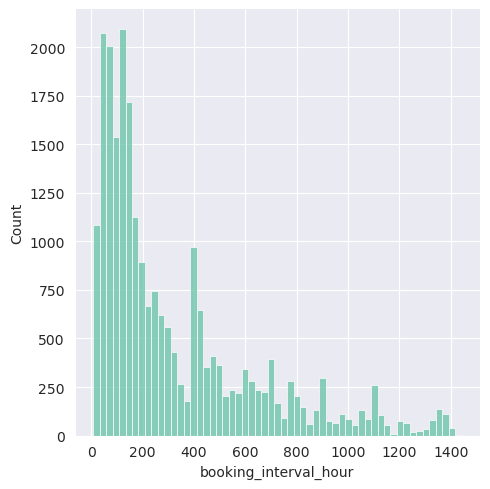

In [30]:
sns.displot(data=data_viz,x="booking_interval_hour")

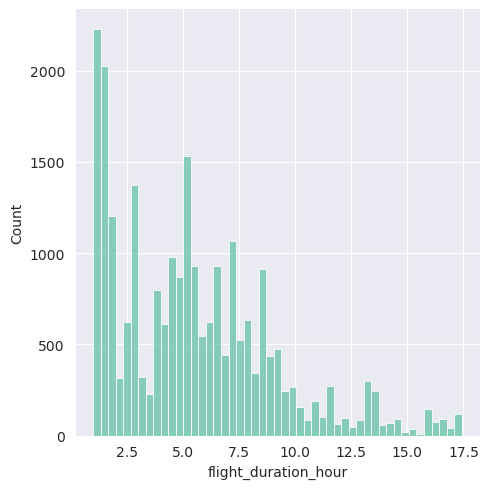

In [31]:
sns.displot(data=data_viz,x="flight_duration_hour")


In [32]:
data_viz.nunique()

departure                    4
airline                      3
planecode                    5
plane                        6
departure_airport            5
ticketprice               3711
flight_duration_hour       169
booking_interval_hour    22304
dtype: int64

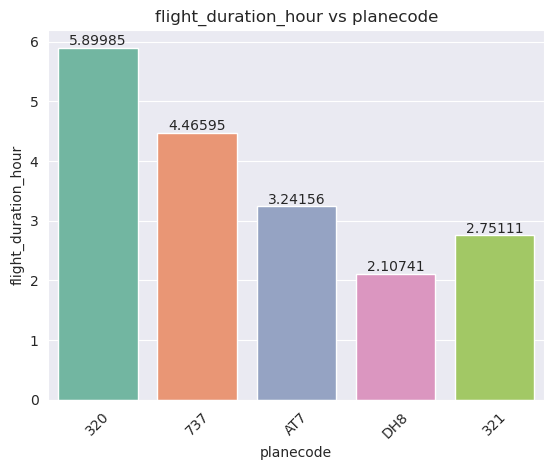

In [33]:
ax = sns.barplot(data=data_viz,y="flight_duration_hour",x="planecode",errorbar=None)
plt.xticks( rotation=45)
plt.title("flight_duration_hour vs planecode")
ax.bar_label(ax.containers[0])
plt.show()

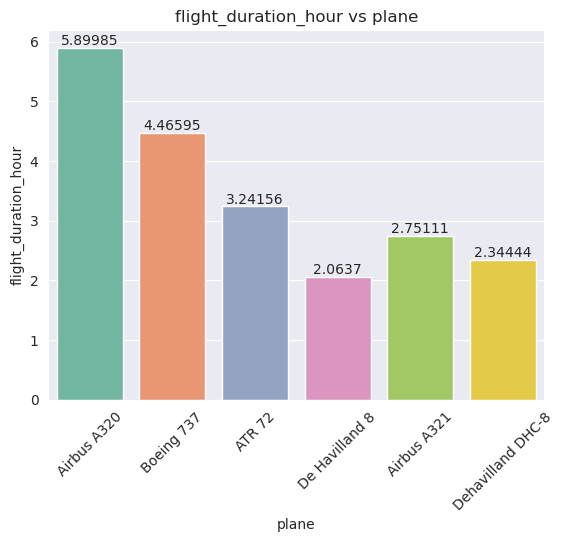

In [34]:
ax = sns.barplot(data=data_viz,y="flight_duration_hour",x="plane",errorbar=None)
plt.xticks( rotation=45)
plt.title("flight_duration_hour vs plane")
ax.bar_label(ax.containers[0])
plt.show()

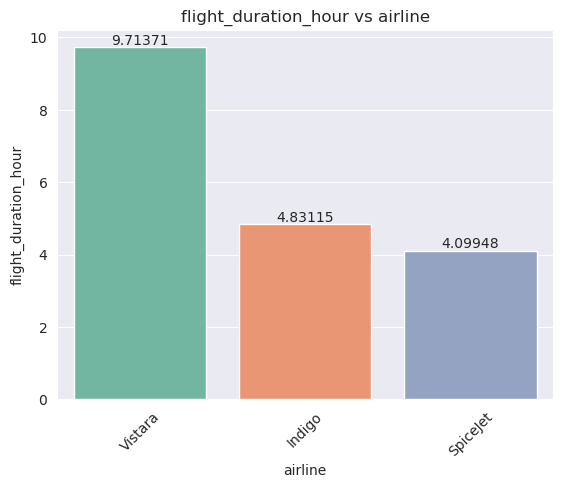

In [35]:
ax = sns.barplot(data=data_viz,y="flight_duration_hour",x="airline",errorbar=None)
plt.xticks( rotation=45)
plt.title("flight_duration_hour vs airline")
ax.bar_label(ax.containers[0])
plt.show()

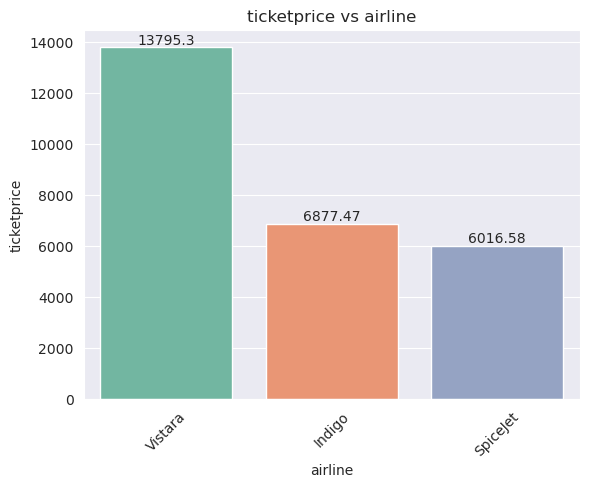

In [36]:
ax = sns.barplot(data=data_viz,y="ticketprice",x="airline",errorbar=None)
plt.xticks( rotation=45)
plt.title("ticketprice vs airline")
ax.bar_label(ax.containers[0])
plt.show()

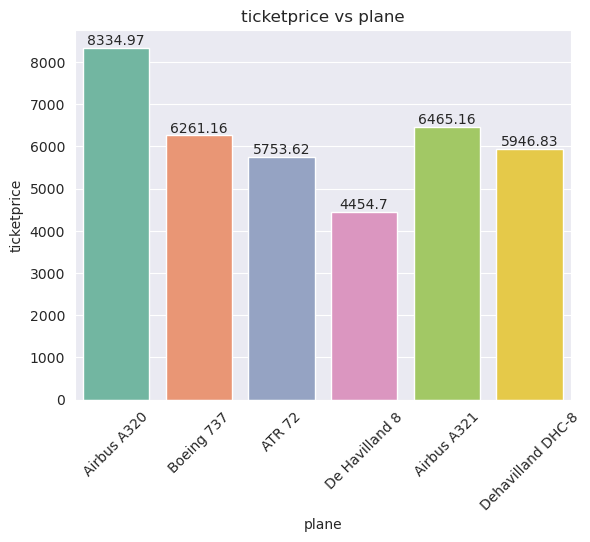

In [37]:
ax = sns.barplot(data=data_viz,y="ticketprice",x="plane",errorbar=None)
plt.xticks( rotation=45)
plt.title("ticketprice vs plane")
ax.bar_label(ax.containers[0])
plt.show()

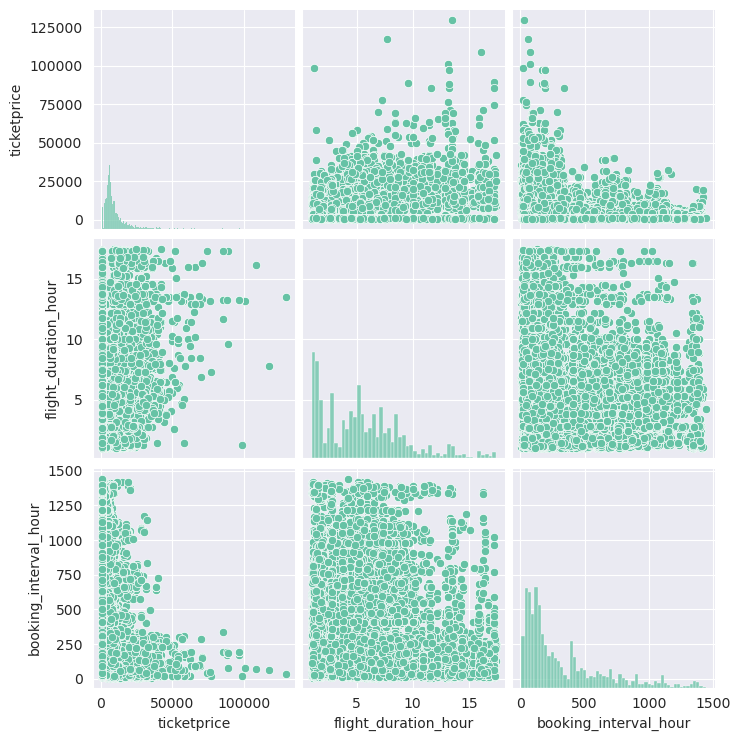

In [38]:
sns.pairplot(data_viz)
plt.show()

/tmp/ipykernel_10539/3412608592.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_viz.corr(),annot=True) #correlation plot


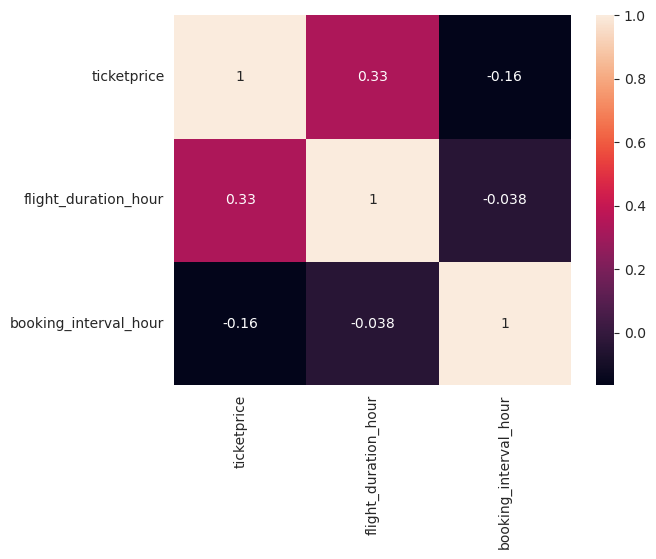

In [39]:
sns.heatmap(data_viz.corr(),annot=True) #correlation plot
plt.show()

---

## One Hot Encoding

In [40]:
cols = df.select_dtypes("O").columns

In [41]:
data = pd.get_dummies(data = data, columns=cols,prefix=cols,drop_first=True)

In [42]:
data.shape

(29999, 199)

----

# Error Matrix

In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#defining MAPE

In [44]:
from sklearn import metrics
import numpy as np
scores = pd.DataFrame(columns=['Model','MAE_Train','MSE_Train','RMSE_Train','MAPE_Train','MAE_Test','MSE_Test','RMSE_Test','MAPE_Test','R^2'])


#definition of error metrics function
def get_metrics(train_act,train_pred,test_act,test_pred,model_description,dataframe):
    MAE_Train = metrics.mean_absolute_error(train_act,train_pred)
    MSE_Train = metrics.mean_squared_error(train_act,train_pred)
    RMSE_Train = np.sqrt(metrics.mean_squared_error(train_act,train_pred))
    MAPE_Train = mean_absolute_percentage_error(train_act,train_pred)
    MAE_Test = metrics.mean_absolute_error(test_act,test_pred)
    MSE_Test = metrics.mean_squared_error(test_act,test_pred)
    RMSE_Test = np.sqrt(metrics.mean_squared_error(test_act,test_pred))
    MAPE_Test = mean_absolute_percentage_error(test_act,test_pred)
    R2=metrics.r2_score(train_act,train_pred)
    s1=pd.Series([model_description,MAE_Train,MSE_Train,RMSE_Train,MAPE_Train,MAE_Test,MSE_Test,RMSE_Test,MAPE_Test,R2],
                                           index=scores.columns)
    dataframe = dataframe.append(s1, ignore_index=True)
    return(dataframe)

----

# Model Building

----

## Linear Regression

In [45]:
train = data.iloc[train_index]
test = data.iloc[test_index]

In [46]:
train.drop([2980, 3097, 3287, 4163, 14809, 16235, 19110, 22786],inplace=True)

/tmp/ipykernel_10539/1869443517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop([2980, 3097, 3287, 4163, 14809, 16235, 19110, 22786],inplace=True)


In [47]:
X_train = train.drop('ticketprice',axis=1)
X_test = test.drop('ticketprice',axis=1)
y_train = train.ticketprice
y_test = test.ticketprice

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23991, 198)
(6000, 198)
(23991,)
(6000,)


In [48]:
X_train= sm.add_constant(X_train)
X_test= sm.add_constant(X_test)

In [49]:
# scaling
scaler = RobustScaler()

cols = ["flight_duration_hour","booking_interval_hour"]

X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols]=scaler.transform(X_test[cols])

In [50]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [51]:
multiple_reg = sm.OLS(y_train, X_train).fit()
print(multiple_reg.summary()) 

                            OLS Regression Results                            
Dep. Variable:            ticketprice   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     71.83
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:34:47   Log-Likelihood:            -2.4974e+05
No. Observations:               23991   AIC:                         4.998e+05
Df Residuals:                   23844   BIC:                         5.010e+05
Df Model:                         146                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [52]:
train_preds = multiple_reg.predict(X_train)
test_preds = multiple_reg.predict(X_test)

In [53]:
#get error metrocs
scores = get_metrics(y_train,train_preds,y_test,test_preds,"Multiple_Linear_Regression",scores)
scores

/tmp/ipykernel_10539/947080141.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(s1, ignore_index=True)


,Model,MAE_Train,MSE_Train,RMSE_Train,MAPE_Train,MAE_Test,MSE_Test,RMSE_Test,MAPE_Test,R^2
0,Multiple_Linear_Regression,4677.78312,6.444231e+07,8027.596538,47.751407,4599.189919,6.039800e+07,7771.615007,47.508008,0.305467


----

# Naive Bayes

In [54]:
# Build a Gaussian Classifier
nb_model = GaussianNB()

# nb_model training
nb_model.fit(X_train, y_train)

GaussianNB()

In [55]:
train_preds = nb_model.predict(X_train)
test_preds = nb_model.predict(X_test)

In [56]:
#get error metrocs
scores = get_metrics(y_train,train_preds,y_test,test_preds,"Naive Bayes",scores)
scores

/tmp/ipykernel_10539/947080141.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(s1, ignore_index=True)


,Model,MAE_Train,MSE_Train,RMSE_Train,MAPE_Train,MAE_Test,MSE_Test,RMSE_Test,MAPE_Test,R^2
0,Multiple_Linear_Regression,4677.783120,6.444231e+07,8027.596538,47.751407,4599.189919,6.039800e+07,7771.615007,47.508008,0.305467
1,Naive Bayes,2132.633321,2.758810e+07,5252.437591,28.619712,2071.736500,2.759930e+07,5253.503440,27.349753,0.702667


----

# KNN Model

In [57]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [58]:
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)

In [59]:
#get error metrocs
scores = get_metrics(y_train,train_preds,y_test,test_preds,"KNN",scores)
scores

/tmp/ipykernel_10539/947080141.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(s1, ignore_index=True)


,Model,MAE_Train,MSE_Train,RMSE_Train,MAPE_Train,MAE_Test,MSE_Test,RMSE_Test,MAPE_Test,R^2
0,Multiple_Linear_Regression,4677.783120,6.444231e+07,8027.596538,47.751407,4599.189919,6.039800e+07,7771.615007,47.508008,0.305467
1,Naive Bayes,2132.633321,2.758810e+07,5252.437591,28.619712,2071.736500,2.759930e+07,5253.503440,27.349753,0.702667
2,KNN,1060.867534,2.131831e+07,4617.175833,8.006914,994.385833,1.856224e+07,4308.392286,7.602435,0.770240


----

# Decision Tree

In [60]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train,y_train)


DecisionTreeRegressor(random_state=42)

In [61]:
train_preds = dt.predict(X_train)
test_preds = dt.predict(X_test)

In [62]:
#get error metrocs
scores = get_metrics(y_train,train_preds,y_test,test_preds,"Decision Tree",scores)
scores

/tmp/ipykernel_10539/947080141.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(s1, ignore_index=True)


,Model,MAE_Train,MSE_Train,RMSE_Train,MAPE_Train,MAE_Test,MSE_Test,RMSE_Test,MAPE_Test,R^2
0,Multiple_Linear_Regression,4677.783120,6.444231e+07,8027.596538,47.751407,4599.189919,6.039800e+07,7771.615007,47.508008,0.305467
1,Naive Bayes,2132.633321,2.758810e+07,5252.437591,28.619712,2071.736500,2.759930e+07,5253.503440,27.349753,0.702667
2,KNN,1060.867534,2.131831e+07,4617.175833,8.006914,994.385833,1.856224e+07,4308.392286,7.602435,0.770240
3,Decision Tree,9.841399,2.870006e+04,169.410929,0.046199,33.865000,9.578113e+05,978.678323,0.107298,0.999691


----